In [15]:
import warnings
warnings.filterwarnings("ignore")

import ddsp
import ddsp.training
#from ddsp.colab.colab_utils import play, specplot, DEFAULT_SAMPLE_RATE
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from IPython.display import Audio

sample_rate = 16000

In [16]:
from IPython.display import Audio
def play(audio):
    return Audio(audio, rate=16000)

In [17]:
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size

# Create a synthesizer object.
harmonic_synth = ddsp.synths.Harmonic(n_samples=n_samples,
                                      sample_rate=sample_rate)

In [18]:
# Generate some arbitrary inputs.

# Amplitude [batch, n_frames, 1].
# Make amplitude linearly decay over time.
amps = np.linspace(1.0, -3.0, n_frames)
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
# Make harmonics decrease linearly with frequency.
n_harmonics = 30
harmonic_distribution = (np.linspace(-2.0, 2.0, n_frames)[:, np.newaxis] + 
                         np.linspace(3.0, -3.0, n_harmonics)[np.newaxis, :])
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 440.0 * np.ones([1, n_frames, 1], dtype=np.float32)

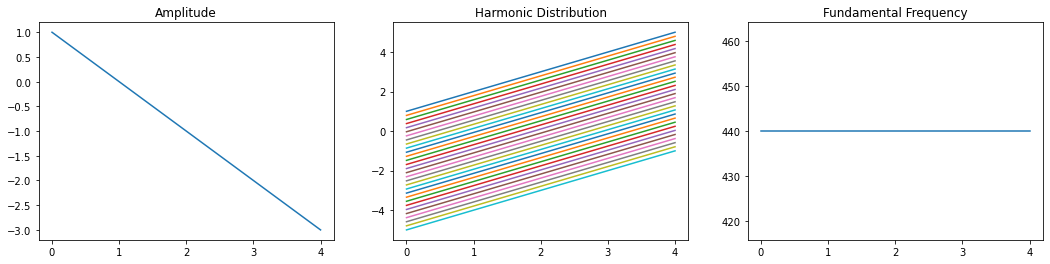

In [19]:
# Plot it!
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, amps[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(132)
plt.plot(time, harmonic_distribution[0, :, :])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(133)
plt.plot(time, f0_hz[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title('Fundamental Frequency')
plt.show()

In [20]:
controls = harmonic_synth.get_controls(amps, harmonic_distribution, f0_hz)
print(controls.keys())

dict_keys(['amplitudes', 'harmonic_distribution', 'f0_hz'])


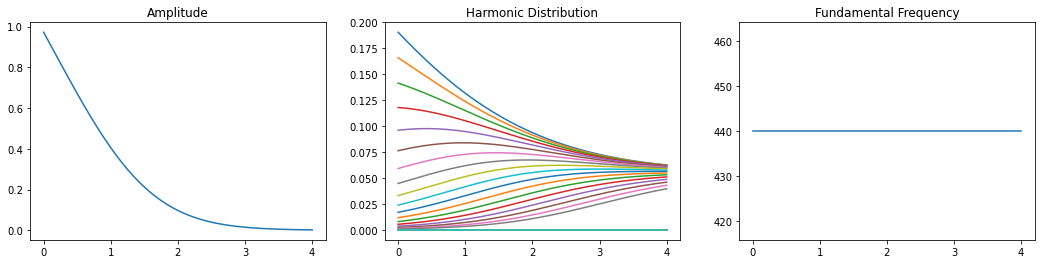

In [21]:
# Now let's see what they look like...
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, controls['amplitudes'][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(132)
plt.plot(time, controls['harmonic_distribution'][0, :, :])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(133)
plt.plot(time, controls['f0_hz'][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title('Fundamental Frequency')
plt.show()

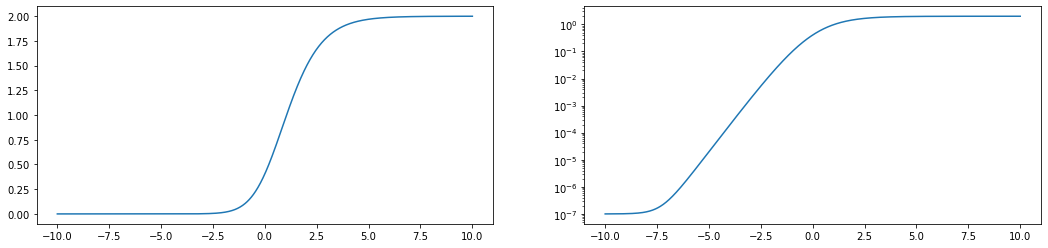

In [22]:
x = tf.linspace(-10.0, 10.0, 1000)
y = ddsp.core.exp_sigmoid(x)

plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(x, y)

plt.subplot(122)
_ = plt.semilogy(x, y)

In [23]:
audio = harmonic_synth.get_signal(**controls)

Audio(audio, rate=16000)

In [24]:
audio = harmonic_synth(amps, harmonic_distribution, f0_hz)

Audio(audio, rate=16000)

In [25]:
## Some weird control envelopes...

# Amplitude [batch, n_frames, 1].
amps = np.ones([n_frames]) * -5.0
amps[:50] +=  np.linspace(0, 7.0, 50)
amps[50:200] += 7.0
amps[200:900] += (7.0 - np.linspace(0.0, 7.0, 700))
amps *= np.abs(np.cos(np.linspace(0, 2*np.pi * 10.0, n_frames)))
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
n_harmonics = 12
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
for i in range(n_harmonics):
  harmonic_distribution[:, i] = 1.0 - np.linspace(i * 0.09, 2.0, 1000)
  harmonic_distribution[:, i] *= 5.0 * np.abs(np.cos(np.linspace(0, 2*np.pi * 0.1 * i, n_frames)))
  if i % 2 != 0:
    harmonic_distribution[:, i] = -3
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = np.ones([n_frames]) * 200.0
f0_hz[:100] *= np.linspace(2, 1, 100)**2
f0_hz[200:1000] += 20 * np.sin(np.linspace(0, 8.0, 800) * 2 * np.pi * np.linspace(0, 1.0, 800))  * np.linspace(0, 1.0, 800)
f0_hz = f0_hz[np.newaxis, :, np.newaxis]

# Get valid controls
controls = harmonic_synth.get_controls(amps, harmonic_distribution, f0_hz)

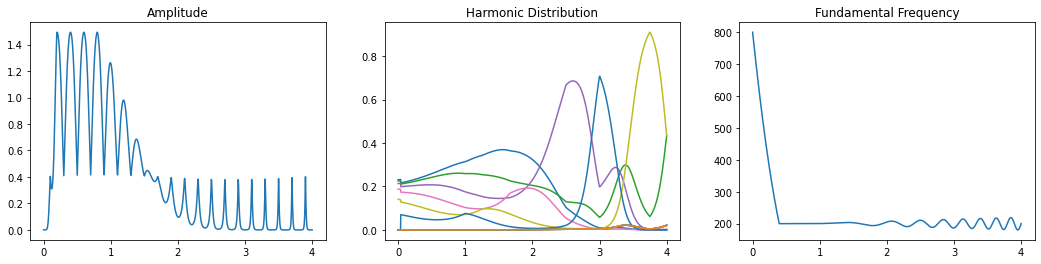

In [26]:
# Plot!
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, controls['amplitudes'][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(132)
plt.plot(time, controls['harmonic_distribution'][0, :, :])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(133)
plt.plot(time, controls['f0_hz'][0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title('Fundamental Frequency')
plt.show()

In [27]:
new = harmonic_synth.get_signal(**controls)

Audio(new, rate=16000)

In [28]:
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size

# Amplitude [batch, n_frames, 1].
# Make amplitude linearly decay over time.
amps = np.linspace(1.0, -3.0, n_frames)
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
# Make harmonics decrease linearly with frequency.
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 440.0 * np.ones([1, n_frames, 1])

In [29]:
# Create synthesizer object.
harmonic_synth = ddsp.synths.Harmonic(n_samples=n_samples,
                                      scale_fn=ddsp.core.exp_sigmoid,
                                      sample_rate=sample_rate)

# Generate some audio.
audio = harmonic_synth(amps, harmonic_distribution, f0_hz)

# Listen.
play(audio)

In [30]:
n_frames = 250
n_frequencies = 1000
n_samples = 64000

# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = [tf.sin(tf.linspace(0.0, w, n_frequencies)) for w in np.linspace(8.0, 80.0, n_frames)]
magnitudes = 0.5 * tf.stack(magnitudes)**4.0
magnitudes = magnitudes[tf.newaxis, :, :]

In [31]:
# Create synthesizer object.
filtered_noise_synth = ddsp.synths.FilteredNoise(n_samples=n_samples, 
                                                 scale_fn=None)

# Generate some audio.
audio = filtered_noise_synth(magnitudes)

# Listen.
play(audio)

In [32]:
n_samples = 64000
n_wavetable = 2048
n_frames = 100

# Amplitude [batch, n_frames, 1].
amps = tf.linspace(0.5, 1e-3, n_frames)[tf.newaxis, :, tf.newaxis]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 110 * tf.linspace(1.5, 1, n_frames)[tf.newaxis, :, tf.newaxis]

# Wavetables [batch, n_frames, n_wavetable].
# Sin wave
wavetable_sin = tf.sin(tf.linspace(0.0, 2.0 * np.pi, n_wavetable))
wavetable_sin = wavetable_sin[tf.newaxis, tf.newaxis, :]

# Square wave
wavetable_square = tf.cast(wavetable_sin > 0.0, tf.float32) * 2.0 - 1.0

# Combine them and upsample to n_frames.
wavetables = tf.concat([wavetable_square, wavetable_sin], axis=1)
wavetables = ddsp.core.resample(wavetables, n_frames)

In [33]:
# Create synthesizer object.
wavetable_synth = ddsp.synths.Wavetable(n_samples=n_samples,
                                        sample_rate=sample_rate,
                                        scale_fn=None)

# Generate some audio.
audio = wavetable_synth(amps, wavetables, f0_hz)

# Listen, notice the aliasing artifacts from linear interpolation.
play(audio)

In [34]:
# Constants
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size


#### Harmonic controls
# Amplitude [batch, n_frames, 1].
amps = np.linspace(0.5, -5.0, n_frames)[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
for i in range(n_harmonics):
  harmonic_distribution[:, i] = 1.0 - np.linspace(i * 0.09, 2.0, 1000)
  if i % 2 != 0:
    harmonic_distribution[:, i] = -3
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = np.linspace(300.0, 200.0, n_frames)[np.newaxis, :, np.newaxis]


### Filtered Noise controls
# Magnitudes [batch, n_frames, n_magnitudes].
n_filter_banks = 20
magnitudes = np.linspace(-1.0, -4.0, n_filter_banks)[np.newaxis, np.newaxis, :]
magnitudes = magnitudes + amps 


### Reverb controls
n_fade_in = 16 * 10
ir_size = int(sample_rate * 2)
n_fade_out = ir_size - n_fade_in

ir = 0.01 * np.random.randn(ir_size)
ir[:n_fade_in] *= np.linspace(0.0, 1.0, n_fade_in)
ir[n_fade_in:] *= np.exp(np.linspace(0.0, -5.0, n_fade_out))
ir = ir[np.newaxis, :]


inputs = {
    'amps': amps,
    'harmonic_distribution': harmonic_distribution,
    'f0_hz': f0_hz,
    'magnitudes': magnitudes,
    'ir': ir,
}
inputs = {k: v.astype(np.float32) for k, v in inputs.items()}

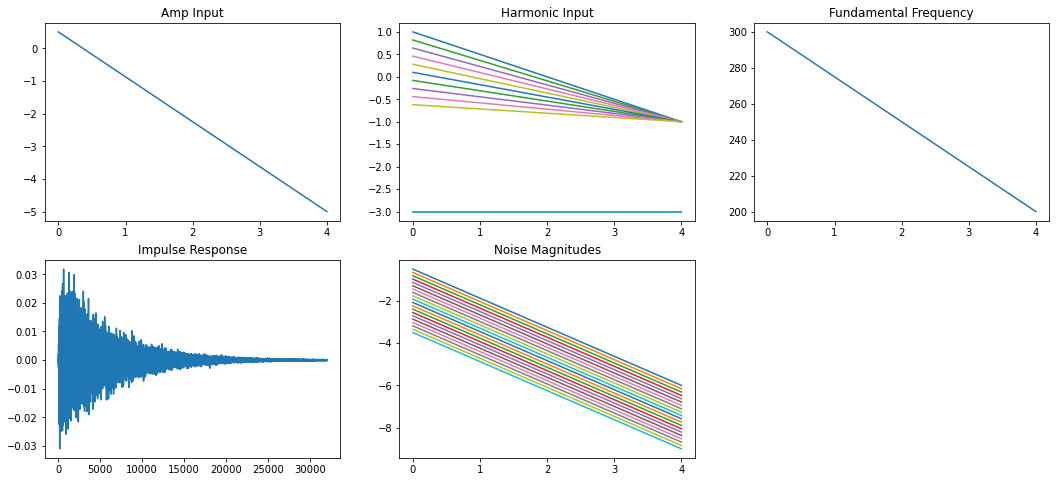

In [35]:
# Plot the inputs
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 8))
plt.subplot(231)
plt.plot(time, amps[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amp Input')

plt.subplot(232)
plt.plot(time, harmonic_distribution[0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Input')

plt.subplot(233)
plt.plot(time, f0_hz[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Fundamental Frequency')

plt.subplot(234)
plt.plot(ir[0])
plt.title('Impulse Response')

plt.subplot(235)
plt.plot(time, magnitudes[0])
plt.xticks([0, 1, 2, 3, 4])
_ = plt.title('Noise Magnitudes')
plt.show()

In [36]:
harmonic = ddsp.synths.Harmonic(n_samples=n_samples)
noise = ddsp.synths.FilteredNoise(n_samples=n_samples, initial_bias=0)
reverb = ddsp.effects.Reverb()

In [37]:
# Python signal processor chain
audio_harmonic = harmonic(inputs['amps'],
                          inputs['harmonic_distribution'],
                          inputs['f0_hz'])
audio_noise = noise(inputs['magnitudes'])
audio_dry = audio_harmonic + audio_noise
audio_out = reverb(inputs['ir'], audio_dry)

# Listen

Audio(audio_out, rate=16000)

In [38]:
print(inputs.keys())

dict_keys(['amps', 'harmonic_distribution', 'f0_hz', 'magnitudes', 'ir'])


In [39]:
harmonic = ddsp.synths.Harmonic(n_samples=n_samples, name='harmonic')
noise = ddsp.synths.FilteredNoise(n_samples=n_samples, name='noise', initial_bias=0.0)
reverb = ddsp.effects.Reverb(name='reverb')
add = ddsp.processors.Add(name='add')

In [40]:
# Processor group DAG
dag = [
  (harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
  (noise, ['magnitudes']),
  (add, ['harmonic/signal', 'noise/signal']),
  (reverb, ['ir', 'add/signal'])
]

processor_group = ddsp.processors.ProcessorGroup(dag=dag)
audio_out = processor_group(inputs)

Audio(audio_out, rate=16000)

In [41]:
processor_group.get_controls(inputs)['out']['signal']

<tf.Tensor: shape=(1, 32000), dtype=float32, numpy=
array([[ 7.6368451e-08,  6.8168129e-06, -1.4559680e-04, ...,
        -2.6622873e-03, -3.8977258e-04,  3.2698386e-04]], dtype=float32)>

In [42]:
outputs = processor_group.get_controls(inputs)

np.set_printoptions(precision=1, threshold=0, edgeitems=1)
for k, v in outputs.items():
  print("'{}':".format(k), v)

'inputs': {'amps': array([[[ 0.5],
        ...,
        [-5. ]]], dtype=float32), 'harmonic_distribution': array([[[ 1., ..., -3.],
        ...,
        [-1., ..., -3.]]], dtype=float32), 'f0_hz': array([[[300.],
        ...,
        [200.]]], dtype=float32), 'magnitudes': array([[[-0.5, ..., -3.5],
        ...,
        [-6. , ..., -9. ]]], dtype=float32), 'ir': array([[0.0e+00, ..., 2.7e-05]], dtype=float32)}
'amps': [[[ 0.5]
  ...
  [-5. ]]]
'harmonic_distribution': [[[ 1. ... -3.]
  ...
  [-1. ... -3.]]]
'f0_hz': [[[300.]
  ...
  [200.]]]
'magnitudes': [[[-0.5 ... -3.5]
  ...
  [-6.  ... -9. ]]]
'ir': [[0.0e+00 ... 2.7e-05]]
'harmonic': {'signal': <tf.Tensor: shape=(1, 64000), dtype=float32, numpy=array([[4.1e-01, ..., 6.2e-07]], dtype=float32)>, 'controls': {'amplitudes': <tf.Tensor: shape=(1, 1000, 1), dtype=float32, numpy=
array([[[6.7e-01],
        ...,
        [2.0e-05]]], dtype=float32)>, 'harmonic_distribution': <tf.Tensor: shape=(1, 1000, 20), dtype=float32, numpy=
array([[[

In [43]:
noise_audio = outputs['noise']['signal']
Audio(noise_audio, rate=16000)

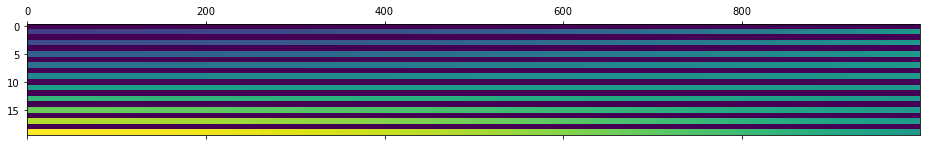

In [44]:
harmonic_distribution_np = outputs['harmonic']['controls']['harmonic_distribution']
_ = plt.matshow(np.rot90(harmonic_distribution_np[0, :, :]), aspect='auto')

In [ ]:
!ddsp_prepare_tfrecord \
  --input_audio_filepatterns=/path/to/wavs/*wav \
  --output_tfrecord_path=/path/to/dataset_name.tfrecord \
  --num_shards=10 \
  --alsologtostderr